In [63]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import xarray as xr
import torch
import torch.nn as nn
from scipy import interpolate
from geopack import geopack
import datetime

In [64]:
def open_reppu(hemi, feature):

    ds = xr.open_dataset(f'/run/media/sachin/0fa21ddb-f70c-4238-9cf4-705e0360f1c1/NICT_Data/{hemi}/multi/{hemi}_2020-2024_{feature}_feats_140_40_2min_rtsw.nc')
    ds = ds.sel(dt=slice('2022-09-17 15:00:00','2022-09-17 22:00:00'))

    df = ds.to_dataframe().reset_index()
    df = df.drop_duplicates(subset=['dt'])
    df = df.drop(columns=['lat', 'lon'])
    var = df.pop(feature)
    df = df[['dt','By', 'Bz', 'vsw', 'np', 'tilt_angle']]

    vals = ds[feature][:-30,:,:].values

    return df,  vals

pot_df, pot_vals = open_reppu('NH', 'pot')
fac_df, fac_vals = open_reppu('NH', 'fac')
sxx_df, sxx_vals = open_reppu('NH', 'sxx')
syy_df, syy_vals = open_reppu('NH', 'syy')
sxy_df, sxy_vals = open_reppu('NH', 'sxy')

In [65]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 40 * 140)

    def forward(self, x):
        batch_size = x.size(0)
        # Use the same device as the model for hidden states
        device = next(self.parameters()).device  # Ensure hidden states are on the same device as the model
        
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size, device=device)  # Initial hidden state
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size, device=device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = out.view(-1, 40, 140)
        return out

    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
lookback = 30
def load_model(model_path,lookback=30):


    model = LSTM(lookback, 128, 2)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)

    return model

#NH
NH_pot_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_pot_NH_id3.pt")
NH_fac_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_fac_NH_id3.pt")
NH_sxx_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_sxx_NH_id3.pt") 
NH_syy_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_syy_NH_id3.pt")
NH_sxy_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_sxy_NH_id3.pt")


In [66]:
'''path = '/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_1min_2013-05.csv'
df = pd.read_csv(path)
df['dt'] = pd.to_datetime(df['dt'])
df = df[df['dt'].between('2013-05-14 04:00:00','2013-05-14 08:30:00')]
#resample to two minutes
df=df.set_index('dt').resample('2min').mean().dropna().reset_index()
df'''

"path = '/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_1min_2013-05.csv'\ndf = pd.read_csv(path)\ndf['dt'] = pd.to_datetime(df['dt'])\ndf = df[df['dt'].between('2013-05-14 04:00:00','2013-05-14 08:30:00')]\n#resample to two minutes\ndf=df.set_index('dt').resample('2min').mean().dropna().reset_index()\ndf"

In [67]:
lookback = 30

def make_predictions(model, df, hemi, feat, id):

    def split_to_df(df):
        df_2 = df.copy()
        df_2 = df_2.drop(columns=['dt'])

        return df, df_2

    with open(f'/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_scaler_{feat}_{hemi}_id{id}.pkl', 'rb') as f:
        scaler = pickle.load(f)

    df_raw, df_proc= split_to_df(df)
    col_names = df_proc.columns

    norm_arr = scaler.transform(df_proc)
    df_proc = pd.DataFrame(norm_arr, columns=col_names)
    df_proc = df_proc.to_numpy()

    def create_sequences(arr, lookback=lookback):
        X = []
        for i in range(len(arr) - lookback):
            X.append(arr[i:i+lookback].T)

        X = np.array(X)

        return X

    proc_seq = create_sequences(df_proc)
    proc_seq = torch.tensor(proc_seq, dtype=torch.float32).to(device)


    predictions = []
    with torch.no_grad():
        for i in range(len(proc_seq)):
            pred = model(proc_seq[i].unsqueeze(0))
            predictions.append(pred)

    predictions = torch.cat(predictions)
    predictions = predictions.to('cpu').numpy()

    return predictions, df_raw

pot_predictions, NH_pot_raw = make_predictions(NH_pot_model, pot_df, 'NH', 'pot', 3)
fac_predictions, NH_fac_raw = make_predictions(NH_fac_model, fac_df, 'NH', 'fac', 3)
sxx_predictions, NH_raw = make_predictions(NH_sxx_model, sxx_df, 'NH', 'sxx', 1)
syy_predictions, NH_raw = make_predictions(NH_syy_model, syy_df, 'NH', 'syy', 1)
sxy_predictions, NH_raw = make_predictions(NH_sxy_model, sxy_df, 'NH', 'sxy', 1)


/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [68]:
#real_pot = pot_vals - lookback

lstm_ds = xr.Dataset({'pot': (['dt', 'mlat', 'mlt'], pot_predictions),
                      'pot_ground': (['dt', 'mlat', 'mlt'], pot_vals),
                      'fac': (['dt', 'mlat', 'mlt'], -fac_predictions),
                      'fac_ground': (['dt', 'mlat', 'mlt'], -fac_vals),
                         'sxx': (['dt', 'mlat', 'mlt'], sxx_predictions),
                         'sxx_ground': (['dt', 'mlat', 'mlt'], sxx_vals),
                         'syy': (['dt', 'mlat', 'mlt'], syy_predictions),
                         'syy_ground': (['dt', 'mlat', 'mlt'], syy_vals),
                         'sxy': (['dt', 'mlat', 'mlt'], sxy_predictions),
                         'sxy_ground': (['dt', 'mlat', 'mlt'], sxy_vals),
                      'BY_GSE': (['dt'], NH_pot_raw['By'].values[lookback:]),
                      'BZ_GSE': (['dt'], NH_pot_raw['Bz'].values[lookback:]),
                      'flow_speed': (['dt'], NH_pot_raw['vsw'].values[lookback:]),
                      'proton_density': (['dt'], NH_pot_raw['np'].values[lookback:]),
                      'tilt_angle': (['dt'], NH_pot_raw['tilt_angle'].values[lookback:]),
                 },
                coords = {'dt': NH_pot_raw['dt'].values[lookback:], 'mlat': np.linspace(50, 90, 40), 'mlt': np.linspace(0, 360, 140)/15})

lstm_ds

<xarray.Dataset> Size: 41MB
Dimensions:         (dt: 181, mlat: 40, mlt: 140)
Coordinates:
  * dt              (dt) datetime64[ns] 1kB 2022-09-17T16:00:00 ... 2022-09-1...
  * mlat            (mlat) float64 320B 50.0 51.03 52.05 ... 87.95 88.97 90.0
  * mlt             (mlt) float64 1kB 0.0 0.1727 0.3453 ... 23.65 23.83 24.0
Data variables: (12/15)
    pot             (dt, mlat, mlt) float32 4MB 0.2773 0.2409 ... -15.03 -15.08
    pot_ground      (dt, mlat, mlt) float32 4MB 1.022 0.9621 ... -9.245 -9.285
    fac             (dt, mlat, mlt) float32 4MB -3.84e-06 3.819e-06 ... -0.09063
    fac_ground      (dt, mlat, mlt) float32 4MB -0.0 -0.0 ... -0.0718 -0.07043
    sxx             (dt, mlat, mlt) float32 4MB 1.956 1.956 ... 3.027 3.025
    sxx_ground      (dt, mlat, mlt) float32 4MB 1.956 1.956 ... 3.435 3.434
    ...              ...
    sxy_ground      (dt, mlat, mlt) float32 4MB 1.625 1.625 ... 3.437 3.436
    BY_GSE          (dt) float64 1kB -2.55 -3.1 -3.5 -4.65 ... -8.0 -7.4 -6.1
    BZ_GSE          (dt) float64 1kB 9.11 8.91 9.01 8.44 ... -0.3 0.645 1.368
    flow_speed      (dt) float64 1kB 351.8 349.9 349.9 ... 360.2 360.2 352.4
    proton_density  (dt) float64 1kB 7.31 7.28 7.28 6.82 ... 6.2 5.54 5.54 7.14
    tilt_angle      (dt) float64 1kB 0.1952 0.1955 0.1958 ... 0.06679 0.06539

<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7284/1803190738.py:20: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_ylabel('IMF\m[nT]')


<xarray.Dataset> Size: 8MB
Dimensions:         (dt: 181, mlat: 25, mlt: 46)
Coordinates:
  * dt              (dt) datetime64[ns] 1kB 2022-09-17T16:00:00 ... 2022-09-1...
  * mlat            (mlat) float64 200B 60.26 61.28 62.31 ... 82.82 83.85 84.87
  * mlt             (mlt) float64 368B 14.16 14.33 14.5 ... 21.58 21.76 21.93
Data variables: (12/15)
    pot             (dt, mlat, mlt) float32 833kB 0.5391 0.577 ... -9.49 -9.753
    pot_ground      (dt, mlat, mlt) float32 833kB 1.066 1.195 ... -3.338 -3.649
    fac             (dt, mlat, mlt) float32 833kB 0.002577 0.002639 ... nan nan
    fac_ground      (dt, mlat, mlt) float32 833kB 0.002544 0.002725 ... nan nan
    sxx             (dt, mlat, mlt) float32 833kB 6.613 6.582 ... 2.487 2.451
    sxx_ground      (dt, mlat, mlt) float32 833kB 6.639 6.619 ... 2.974 2.945
    ...              ...
    sxy_ground      (dt, mlat, mlt) float32 833kB 6.351 6.339 ... 3.023 2.992
    BY_GSE          (dt) float64 1kB -2.55 -3.1 -3.5 -4.65 ... -8.0 -7.4 -6.1
    BZ_GSE          (dt) float64 1kB 9.11 8.91 9.01 8.44 ... -0.3 0.645 1.368
    flow_speed      (dt) float64 1kB 351.8 349.9 349.9 ... 360.2 360.2 352.4
    proton_density  (dt) float64 1kB 7.31 7.28 7.28 6.82 ... 6.2 5.54 5.54 7.14
    tilt_angle      (dt) float64 1kB 0.1952 0.1955 0.1958 ... 0.06679 0.06539

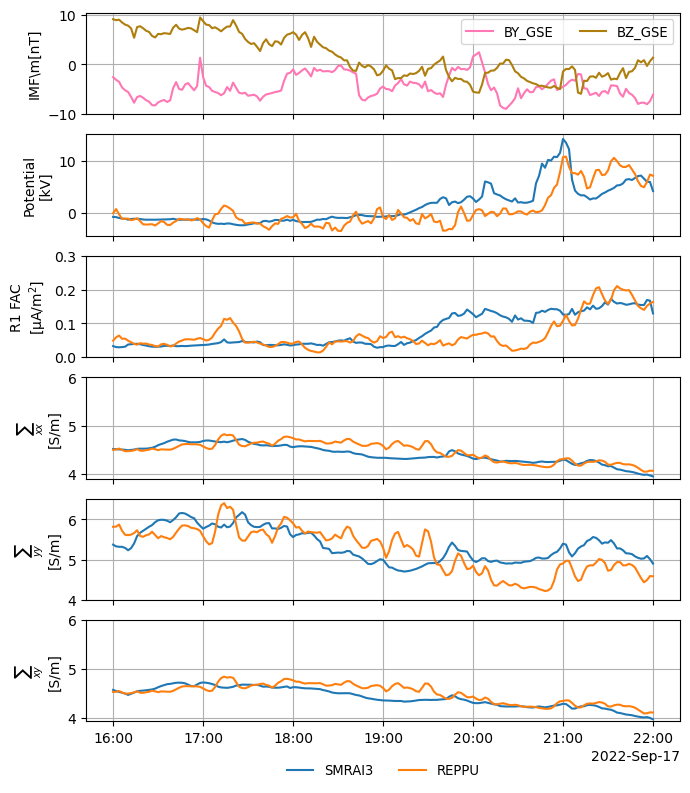

In [109]:
def plot_line(ds):
    ds = ds.copy()

    ds = ds.sel(mlat=slice(60, 85), mlt=slice(14, 22))
    #keep data between 14 and 22 MLT and nan/mask the rest
    #ds = ds.where((ds['mlt'] >= 14) & (ds['mlt'] <= 23.9), np.nan)
    #ds['pot'] = ds['pot'].where(ds['pot'] > 1)
    #s['pot_ground'] = ds['pot_ground'].where(ds['pot_ground'] > 0)
    ds['fac'] = ds['fac'].where(ds['fac'] > 0)
    ds['fac_ground'] = ds['fac_ground'].where(ds['fac_ground'] > 0)

    #ds['fac'] = ds['fac'].where(ds['fac'] > 0)

    #slice between 14 and 16 mlt
    fig, ax = plt.subplots(6,1,figsize=(7, 8),sharex=True)

    ds['BY_GSE'].plot(ax=ax[0], label='BY_GSE', color = '#ff77b4')
    ds['BZ_GSE'].plot(ax=ax[0], label='BZ_GSE', color = '#af7f0e')
    ax[0].legend(loc='upper right',shadow=False, ncol=5, frameon=True, fontsize=9.5)
    ax[0].set_ylabel('IMF\m[nT]')
    ax[0].set_xlabel(' ')
    ax[0].set_yticks([-10, 0, 10])


    ds['pot'].mean(dim=['mlt','mlat']).plot(ax=ax[1], label='SMRAI3')
    ds['pot_ground'].mean(dim=['mlt','mlat']).plot(ax=ax[1], label='REPPU')
    ax[1].set_ylabel('Potential\n[kV]')
    ax[1].set_xlabel(' ')

    ds['fac'].mean(dim=['mlt','mlat']).plot(ax=ax[2], label='SMRAI3')
    ds['fac_ground'].mean(dim=['mlt','mlat']).plot(ax=ax[2], label='REPPU')
    fac_lab = r'$\mathregular{\mu A/m^2}$'
    ax[2].set_ylabel(f'R1 FAC\n[{fac_lab}]')
    ax[2].set_xlabel(' ')
    ax[2].set_yticks([0, 0.1, 0.2, 0.3])

    ds['sxx'].mean(dim=['mlt','mlat']).plot(ax=ax[3], label='SMRAI3')
    ds['sxx_ground'].mean(dim=['mlt','mlat']).plot(ax=ax[3], label='REPPU')
    sum_lab = r'$\sum_{xx}$'
    ax[3].set_ylabel(f'{sum_lab}\n[S/m]')
    ax[3].set_xlabel(' ')
    ax[3].set_yticks([4, 5, 6])


    sum_lab = r'$\sum_{yy}$'
    ds['syy'].mean(dim=['mlt','mlat']).plot(ax=ax[4], label='SMRAI3')
    ds['syy_ground'].mean(dim=['mlt','mlat']).plot(ax=ax[4], label='REPPU')
    ax[4].set_ylabel(f'{sum_lab}\n[S/m]')
    ax[4].set_xlabel(' ')
    ax[4].set_yticks([4, 5, 6])

    sum_lab = r'$\sum_{xy}$'
    ds['sxy'].mean(dim=['mlt','mlat']).plot(ax=ax[5], label='SMRAI3')
    ds['sxy_ground'].mean(dim=['mlt','mlat']).plot(ax=ax[5], label='REPPU')
    ax[5].set_ylabel(f'{sum_lab}\n[S/m]')
    ax[5].set_yticks([4, 5, 6])
    ax[5].set_xlabel(' ')
    ax[5].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), shadow=False, ncol=5, frameon=False, fontsize=9.5)
    plt.tight_layout()

    for axs in ax:
        axs.grid(True)

    fig.subplots_adjust(hspace=0.2)
    return ds

plot_line(lstm_ds)

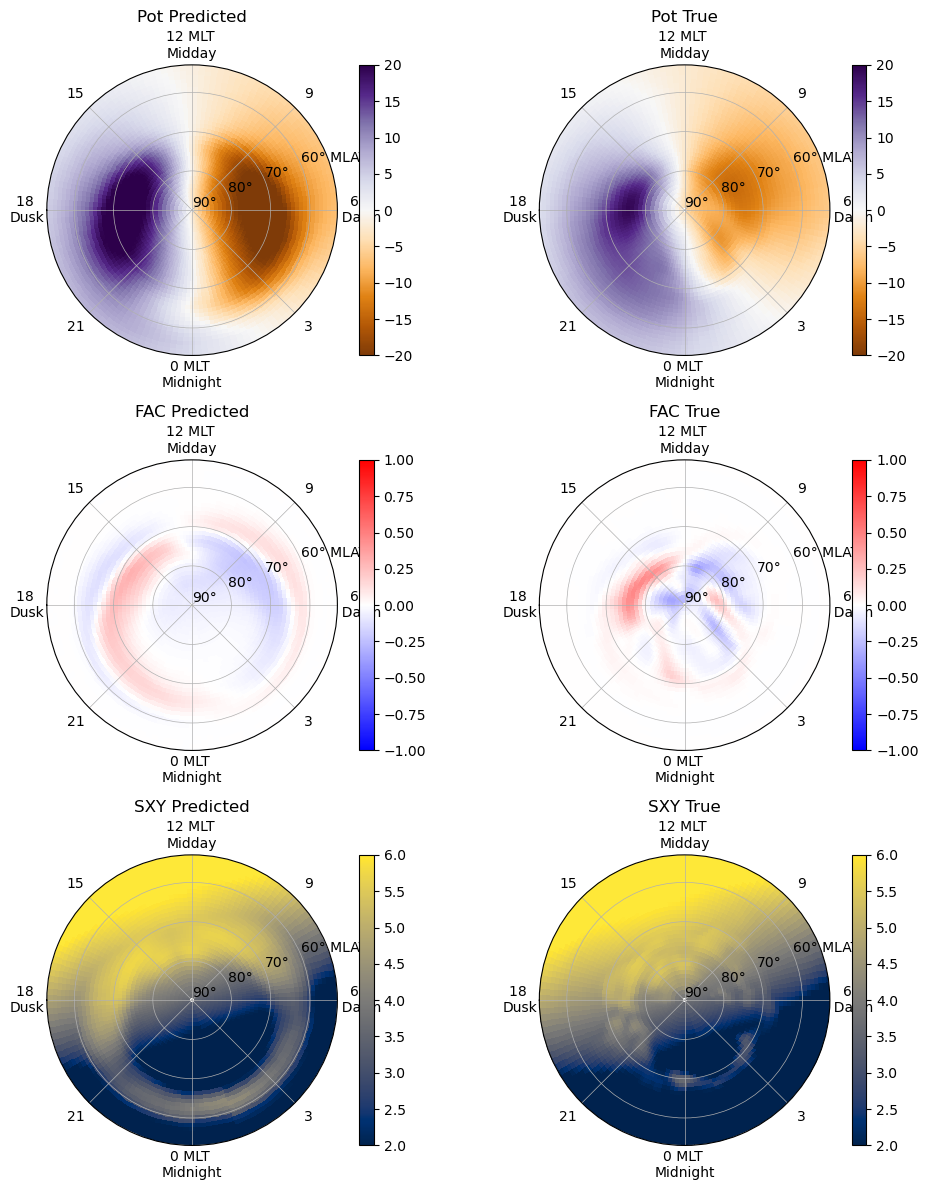

In [144]:
def plot_substorm(ds):
    fig, ax = plt.subplots(3, 2, figsize=(10, 12), sharex=True, sharey=False, subplot_kw={'projection': 'polar'})

    theta = np.linspace(0, 360, 140) - 90
    theta_rad = np.deg2rad(theta)
    r = 90 - np.linspace(50, 90, 40)

    ds = ds.sel(dt=slice('2022-09-17T21:00:00', '2022-09-17T21:00:00'))

    pot_pred = ds['pot'].values.reshape(40, 140)
    pot_true = ds['pot_ground'].values.reshape(40, 140)

    fac_pred = ds['fac'].values.reshape(40, 140)
    fac_true = ds['fac_ground'].values.reshape(40, 140)

    sxy_pred = ds['sxy'].values.reshape(40, 140)
    sxy_true = ds['sxy_ground'].values.reshape(40, 140)

    # Plotting each subplot directly
    c1 = ax[0, 0].pcolormesh(theta_rad, r, pot_pred,cmap='PuOr', vmin=-20, vmax=20)
    ax[0, 0].set_title('Pot Predicted')
    plt.colorbar(c1, ax=ax[0, 0], orientation='vertical')

    c2 = ax[0, 1].pcolormesh(theta_rad, r, pot_true,cmap='PuOr', vmin=-20, vmax=20)
    ax[0, 1].set_title('Pot True')
    plt.colorbar(c2, ax=ax[0, 1], orientation='vertical')

    c3 = ax[1, 0].pcolormesh(theta_rad, r, fac_pred, cmap='bwr', vmin=-1, vmax=1)
    ax[1, 0].set_title('FAC Predicted')
    plt.colorbar(c3, ax=ax[1, 0], orientation='vertical')

    c4 = ax[1, 1].pcolormesh(theta_rad, r, fac_true, cmap='bwr', vmin=-1, vmax=1)
    ax[1, 1].set_title('FAC True')
    plt.colorbar(c4, ax=ax[1, 1], orientation='vertical')

    c5 = ax[2, 0].pcolormesh(theta_rad, r, sxy_pred, cmap='cividis', vmin=2, vmax=6)
    ax[2, 0].set_title('SXY Predicted')
    plt.colorbar(c5, ax=ax[2, 0], orientation='vertical')

    c6 = ax[2, 1].pcolormesh(theta_rad, r, sxy_true, cmap='cividis', vmin=2, vmax=6)
    ax[2, 1].set_title('SXY True')
    plt.colorbar(c6, ax=ax[2, 1], orientation='vertical', label='S/m')

            # Setting common limits and labels
    for axs in ax.flatten():
        axs.set_ylim([0, 37])
        axs.set_yticks([0, 10, 20, 30])
        axs.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
        axs.set_xlim([-np.pi, np.pi])
        axs.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
        axs.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
        axs.grid(True, linestyle='-', linewidth=0.5, zorder=6)



    plt.tight_layout()
    plt.show()

# Call the function with your dataset
plot_substorm(lstm_ds)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_substorm(ds):
    fig, ax = plt.subplots(3, 2, figsize=(10, 12), sharex=True, sharey=False, subplot_kw={'projection': 'polar'})

    theta = np.linspace(0, 360, 24) - 90
    theta_rad = np.deg2rad(theta)
    r = 90 - np.linspace(40, 90, 50)

    def shape_flip(arr):
        arr = arr.reshape(24, 50).T
        arr = np.flipud(arr)
        return arr

    # Defining time slices
    times = [
        ('2013-05-14T07:00:00', '2013-05-14T07:00:00'),
        ('2013-05-14T07:30:00', '2013-05-14T07:30:00'),
        ('2013-05-14T08:00:00', '2013-05-14T08:00:00'),
    ]
    
    for i, (start_time, end_time) in enumerate(times):
        plot_ds = ds.sel(dt=slice(start_time, end_time))

        NH_true = shape_flip(plot_ds['jPar_NH_true'].mean(dim='dt').values)
        NH_pred = shape_flip(plot_ds['jPar_NH_pred'].mean(dim='dt').values)

        R = np.corrcoef(NH_true.flatten(), NH_pred.flatten())[1, 0]
        MAE = np.mean(np.abs(NH_true.flatten() - NH_pred.flatten()))
        fac_units = r'$\mathrm{\mu}$A/m$^2$'

        # Observation plot (left column)
        int_label = r'$\int_{60°}^{90°}$'
        c0 = ax[i, 0].pcolormesh(theta_rad, r, NH_true, cmap='bwr', vmin=-1, vmax=1)
        int_obs = (np.sum(np.abs(NH_true[20:,:]) * areas[20:,:])) / 1e12
        ax[i, 0].annotate(f'{int_label}: {int_obs:.1f} MA', xytext=(0.95, 1.05), xy=(0, 0), textcoords='axes fraction',
                          va='center', ha='center', fontsize=11)

        # Prediction plot (right column)
        c1 = ax[i, 1].pcolormesh(theta_rad, r, NH_pred, cmap='bwr', vmin=-1, vmax=1)
        int_pred = (np.sum(np.abs(NH_pred[20:,:]) * areas[20:,:])) / 1e12
        ax[i, 1].annotate(f'{int_label}: {int_pred:.1f} MA', xytext=(0.95, 1.05), xy=(0, 0), textcoords='axes fraction',
                            va='center', ha='center', fontsize=10.5)

        # Annotating date on the left side
        ax[i, 0].text(-0.25, 0.5, f'{start_time[11:16]} UT', transform=ax[i, 0].transAxes,
                      fontsize=11, va='center', ha='center', rotation=90)
        
        # Annotate on the right hand side
        ax[i, 1].text(1.35, 0.5, f'MAE: {MAE:.2f} {fac_units}\nR: {R:.2f}', transform=ax[i, 1].transAxes,
                      fontsize=11, va='center', ha='center', rotation=90)

        # Setting common limits and labels
        for j in range(2):
            ax[i, j].set_ylim([0, 37])
            ax[i, j].set_yticks([0, 10, 20, 30])
            ax[i, j].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
            ax[i, j].set_xlim([-np.pi, np.pi])
            ax[i, j].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
            ax[i, j].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
            ax[i, j].grid(True, linestyle='-', linewidth=0.5, zorder=6)

        #add a, b, c to top left of each subplot with a slight offset
        for j in range(2):
            ax[i, j].text(0.01, 1.1, f'{chr(97 + 2*i + j)}.', transform=ax[i, j].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='center', fontweight='bold')

    # Adding column titles
    ax[2, 0].annotate('Observation\n(AMPERE)', xy=(0.5, 0), xytext=(0.5, -0.3), 
                      textcoords='axes fraction', va='center', ha='center', fontsize=12, linespacing=1.5)
    ax[2, 1].annotate('Prediction\n(MAMBA)', xy=(0.5, 0), xytext=(0.5, -0.3),
                      textcoords='axes fraction', va='center', ha='center', fontsize=12, linespacing=1.5)

    # Adding a colorbar at the bottom
    cbar_ax = fig.add_axes([0.382, 0.06, 0.2, 0.01])  # [left, bottom, width, height]
    cbar = fig.colorbar(c1, cax=cbar_ax, orientation='horizontal', label=r'FAC / J$_\parallel$ [µA/m$^2$]', extend='both')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.25, hspace=0.5)
    plt.savefig('substorm_2013-05-14_ampere_LSTM.png', dpi=500)
    # plt.show()

# Example call to function
plot_substorm(lstm_ds)


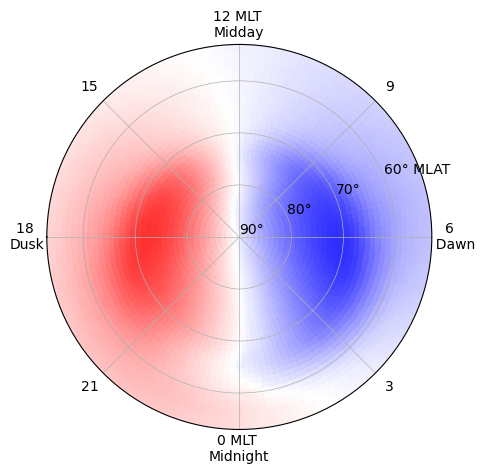

In [110]:
fig, ax = plt.subplots(1,1,figsize=(5, 5), subplot_kw={'projection': 'polar'})

theta = np.linspace(0, 360, 140) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(50, 90, 40)

pred = lstm_ds['pot'].isel(dt=150).values

#pred = -pred

ax.pcolormesh(theta_rad, r, pred, cmap='bwr', vmin=-30, vmax=30)
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-', linewidth=0.5, zorder=6)

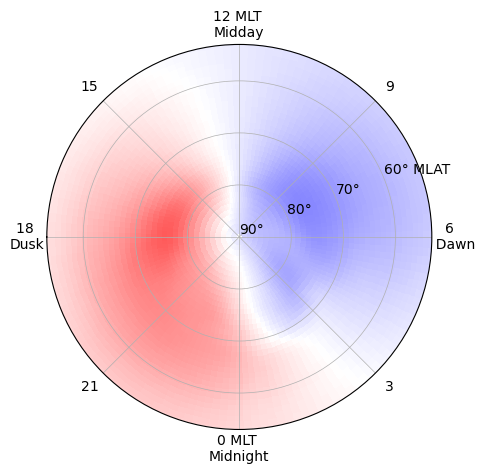

In [111]:
fig, ax = plt.subplots(1,1,figsize=(5, 5), subplot_kw={'projection': 'polar'})

theta = np.linspace(0, 360, 140) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(50, 90, 40)

pred = lstm_ds['pot_ground'].isel(dt=150).values

#pred = -pred

ax.pcolormesh(theta_rad, r, pred, cmap='bwr', vmin=-30, vmax=30)
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-', linewidth=0.5, zorder=6)

In [72]:
fig, ax = plt.subplots(1,1,figsize=(5, 5), subplot_kw={'projection': 'polar'})

theta = np.linspace(0, 360, 140) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(50, 90, 40)

pred = lstm_ds['pot_ground'].isel(dt=150).values

#pred = -pred

ax.pcolormesh(theta_rad, r, pred, cmap='bwr', vmin=-30, vmax=30)
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-', linewidth=0.5, zorder=6)

<xarray.DataArray 'fac' (mlat: 40, mlt: 140)> Size: 22kB
array([[-1.9054096e-07,  9.9702384e-06,  6.0848247e-06, ...,
        -9.3851741e-06, -5.7752095e-06,  1.2818600e-06],
       [ 3.6012943e-07, -1.4225674e-05,  1.6264610e-05, ...,
         4.1289059e-07, -1.2768733e-05, -7.1193676e-06],
       [-8.3126833e-06, -5.6883164e-06,  1.7010358e-05, ...,
        -2.0945513e-06,  1.3554102e-05,  1.0054008e-05],
       ...,
       [-1.4267671e-01, -1.3878120e-01, -1.3497365e-01, ...,
        -1.6501354e-01, -1.6168745e-01, -1.5906098e-01],
       [-1.6686472e-01, -1.6376217e-01, -1.6088605e-01, ...,
        -1.9066274e-01, -1.8744320e-01, -1.8487459e-01],
       [-1.9258435e-01, -1.9099249e-01, -1.8823363e-01, ...,
        -2.1112432e-01, -2.1033864e-01, -2.0958900e-01]], dtype=float32)
Coordinates:
    dt       datetime64[ns] 8B 2022-09-17T17:20:00
  * mlat     (mlat) float64 320B 50.0 51.03 52.05 53.08 ... 87.95 88.97 90.0
  * mlt      (mlt) float64 1kB 0.0 0.1727 0.3453 0.518 ... 23.65 23.83 24.0

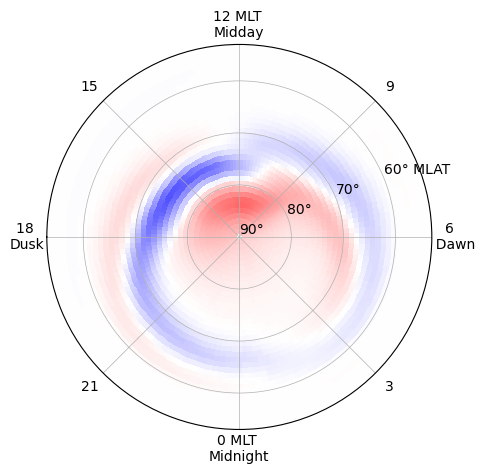

In [73]:
fig, ax = plt.subplots(1,1,figsize=(5, 5), subplot_kw={'projection': 'polar'})

theta = np.linspace(0, 360, 140) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(50, 90, 40)

pred = lstm_ds['fac'].isel(dt=135).values

pred = -pred

ax.pcolormesh(theta_rad, r, pred, cmap='bwr', vmin=-.5, vmax=.5)
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-', linewidth=0.5, zorder=6)

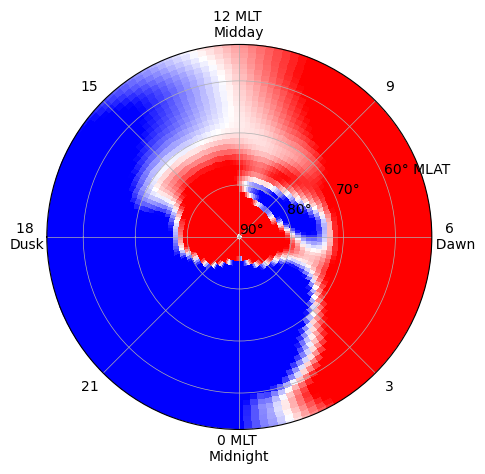

In [74]:
fig, ax = plt.subplots(1,1,figsize=(5, 5), subplot_kw={'projection': 'polar'})

theta = np.linspace(0, 360, 140) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(50, 90, 40)

pred = lstm_ds['pot_ground'].isel(dt=135).values

pred = -pred

ax.pcolormesh(theta_rad, r, pred, cmap='bwr', vmin=-.5, vmax=.5)
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-', linewidth=0.5, zorder=6)